In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 

from sklearn.model_selection import StratifiedKFold

import cudf 
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier


import os,glob

In [2]:
project_dir = os.getcwd()
data_dir = os.path.join(project_dir, 'data')

data_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))

<Axes: >

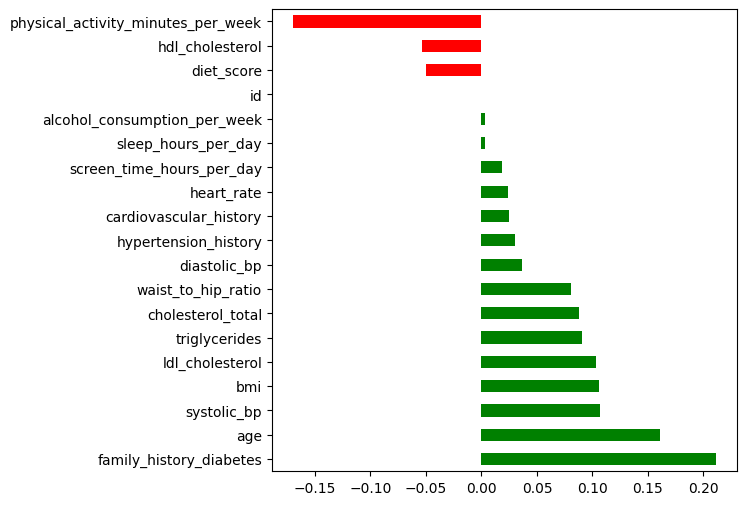

In [3]:
numerical_data  = data_csv.select_dtypes(include=[np.number])
corr_matrix     = numerical_data.corr()

fig, ax = plt.subplots(figsize=(10, 10)) 
diabetes_corr = corr_matrix['diagnosed_diabetes'].drop('diagnosed_diabetes').sort_values(ascending=False)

colors = ['green' if x > 0 else 'red' for x in diabetes_corr]
diabetes_corr.plot(kind='barh', color=colors, figsize=(6, 6)) 

In [4]:
def clinical_features(df_raw):

    df = df_raw.copy()

    ### Risk Factors ###

    df['ada_risk_factor_count'] = (
        (df['gender'] == 'Male').astype(int)
        + (df['age'] > 35).astype(int)
        + (df['bmi'] >= 25).astype(int)
        + (df['bmi'] >= 30).astype(int)
        + (df['bmi'] >= 35).astype(int)
        + (df['physical_activity_minutes_per_week'] < 100).astype(int)
        + (df['systolic_bp'] >= 130) | (df['diastolic_bp'] >= 80).astype(int)
        + (df['hdl_cholesterol'] < 35).astype(int)
        + (df['triglycerides'] > 150).astype(int)
        + df['family_history_diabetes'] 
        + df['hypertension_history']  
        + df['cardiovascular_history'] 
        )

    df['bp_normal'] = (
        (df['systolic_bp'] < 120) & 
        (df['diastolic_bp'] < 80) ).astype(int)

    # LIFE STYLE
    df['toxic_lifestyle'] = (
        (df['diet_score'] < 5).astype(int) +
        (df['sleep_hours_per_day'] < 7).astype(int) +
        (df['screen_time_hours_per_day'] > 6).astype(int) +
        (df['alcohol_consumption_per_week'] > 7).astype(int) +
        (df['physical_activity_minutes_per_week'] < 100).astype(int)
    )
     
    df['age_bmi'] = df['age'] * df['bmi']

    df['age_family_history'] = df['age'] * df['family_history_diabetes']
    df['bmi_family_history'] = df['bmi'] * df['family_history_diabetes']
    df['age_bmi_family_history'] = df['age'] * df['bmi'] * df['family_history_diabetes']
    
    # cardiovascular burden 
    df['cardio_comorbidity_count'] = (
        df['hypertension_history'] +
        df['cardiovascular_history'] +
        df['family_history_diabetes']
    )

    return df
    
data_csv2 = clinical_features(data_csv)

['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes', 'ada_risk_factor_count', 'bp_normal', 'toxic_lifestyle', 'age_bmi', 'age_family_history', 'bmi_family_history', 'age_bmi_family_history', 'cardio_comorbidity_count']


<Axes: >

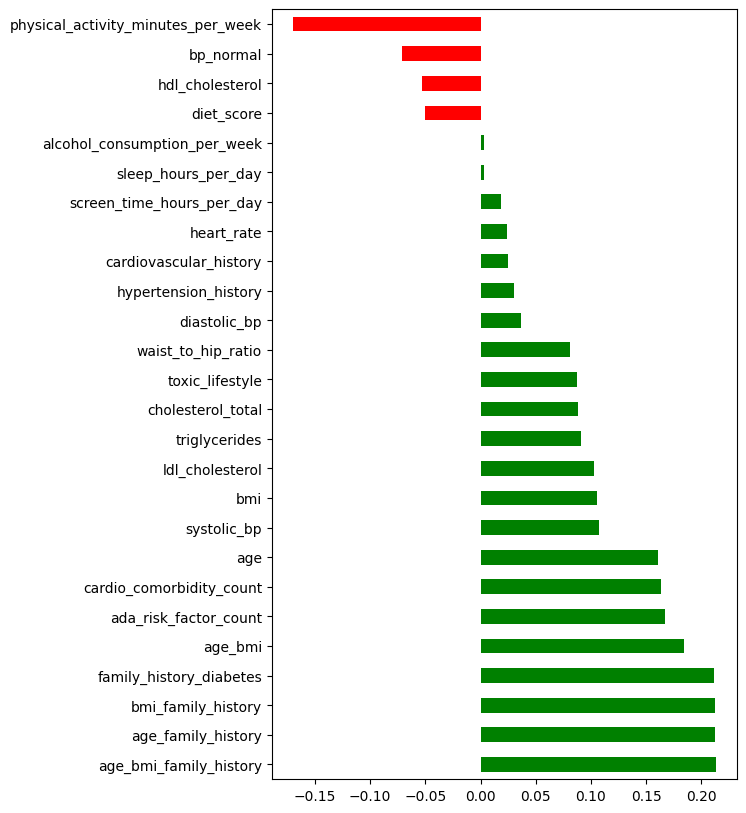

In [5]:
numerical_features = data_csv2.select_dtypes(include=[np.number]).columns.drop(['id']).tolist(); print(numerical_features)

corr_matrix = data_csv2[numerical_features].corr()
diab_corr   = corr_matrix['diagnosed_diabetes'].drop('diagnosed_diabetes').sort_values(ascending=False)

colors = ['green' if x > 0 else 'red' for x in diab_corr]
diab_corr.plot(kind='barh', color=colors, figsize=(6, 10))

In [6]:
train_data , test_data = train_test_split(data_csv2, test_size=0.2, random_state=8964)

In [7]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression


max_iter = 2000
c_value  = 1.0
random_state = 8964

models = {
    'Logistic (L2)' : LogisticRegression(penalty='l2', C= c_value, max_iter=max_iter),
    'Logistic (L1)' : LogisticRegression(penalty='l1', C= c_value, max_iter=max_iter),
    'Logistic ElasticNet' : LogisticRegression(penalty='elasticnet', C= c_value, max_iter=max_iter, l1_ratio=0.5),
    'RandomForest'  : RandomForestClassifier(n_estimators=100, max_depth=6, random_state=random_state),
    'XGBoost'       : XGBClassifier(tree_method = 'hist', n_estimators=100, device = 'cuda' ,learning_rate=0.1, max_depth=6, random_state=random_state),
    'LightGBM'      : LGBMClassifier(n_estimators=100, device='gpu', learning_rate=0.1, max_depth=6, random_state=random_state),
    'CatBoost'      : CatBoostClassifier(n_estimators=100, task_type='GPU', learning_rate=0.1, max_depth=6, random_state=random_state)
}

In [8]:

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

n_fold = 5 

stratified_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=8964)
kfold = stratified_kfold.split(train_data, train_data['diagnosed_diabetes'])

numerical_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

results = []

for i, (train_idx, valid_idx) in enumerate(kfold):
    print(f'Fold {i+1} : train_idx {len(train_idx)}, valid_idx {len(valid_idx)}')
    print('- ' * 16)

    train_inputs = train_data[numerical_features].drop(columns=['id', 'diagnosed_diabetes']).iloc[train_idx]
    valid_inputs = train_data[numerical_features].drop(columns=['id', 'diagnosed_diabetes']).iloc[valid_idx]
    train_target = train_data['diagnosed_diabetes'].iloc[train_idx]
    valid_target = train_data['diagnosed_diabetes'].iloc[valid_idx]
 
    train_inputs_gpu = cudf.DataFrame(train_inputs) 
    train_target_gpu = cudf.Series(train_target.values)  
    valid_inputs_gpu = cudf.DataFrame(valid_inputs) 
    valid_target_gpu = cudf.Series(valid_target.values)
    
    for name, model in models.items():
        if 'Logistic' in name or 'RandomForest' in name:
            model.fit(train_inputs_gpu, train_target_gpu)
        
            pred = model.predict(valid_inputs_gpu)
            pred_proba = model.predict_proba(valid_inputs_gpu)
         
            pred_proba = pred_proba.values.get()[:, 1]  
            pred = pred.values.get()  # Convert to numpy
        else: 
            model.fit(train_inputs, train_target)
            pred = model.predict(valid_inputs)
            pred_proba = model.predict_proba(valid_inputs)[:,1]

        acc = accuracy_score(pred, valid_target)
        auc = roc_auc_score(valid_target, pred_proba)

        print(f"Model: {name},  Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")
        results.append({'Fold': i, 'Model': name, 'Accuracy': acc, 'ROC-AUC': auc})
    

    # train_value_counts = train_target.value_counts()
    # train_value_counts_ratio = train_value_counts[1] / train_value_counts.sum()

    # valid_value_counts = valid_target.value_counts()
    # valid_value_counts_ratio = valid_value_counts[1] / valid_value_counts.sum()

    # print(f'[train] diagonsed_diabetes positive ratio: {train_value_counts_ratio}')
    # print(f'[valid] diagonsed_diabetes positive ratio: {valid_value_counts_ratio}')

    # log_clf, rf_clf = baseline_model(train_inputs, train_target, valid_inputs, valid_target, random_state=8964)
    # evalulate_model_accuracy(log_clf, rf_clf, valid_inputs, valid_target)

    print('-' * 16)


Fold 1 : train_idx 448000, valid_idx 112000
- - - - - - - - - - - - - - - - 
Model: Logistic (L2),  Accuracy: 0.6634, ROC-AUC: 0.6954
Model: Logistic (L1),  Accuracy: 0.6633, ROC-AUC: 0.6956
Model: Logistic ElasticNet,  Accuracy: 0.6632, ROC-AUC: 0.6956
Model: RandomForest,  Accuracy: 0.6592, ROC-AUC: 0.6919


/scratch/k/K.Choi/diabetes-diagonsis/stats_tools/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [11:50:22] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Model: XGBoost,  Accuracy: 0.6787, ROC-AUC: 0.7198
[LightGBM] [Info] Number of positive: 279184, number of negative: 168816
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 448000, number of used features: 26
[LightGBM] [Info] Using GPU Device: NVIDIA A40, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 19 dense feature groups (8.54 MB) transferred to GPU in 0.014859 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623179 -> initscore=0.503062
[LightGBM] [Info] Start training from score 0.503062
Model: LightGBM,  Accuracy: 0.6784, ROC-AUC: 0.7193
0:	learn: 0.6753073	total: 603ms	remaining: 59.7s
1:	learn: 0.6612977	total: 609ms	remaining: 29.8s
2:	learn: 0.6503173	total: 614ms	remaining: 19.8s
3:	learn: 0.6415478	total: 

In [9]:
results_df = pd.DataFrame(results)
display(results_df)

,Fold,Model,Accuracy,ROC-AUC
0,0,Logistic (L2),0.663420,0.695419
1,0,Logistic (L1),0.663268,0.695639
2,0,Logistic ElasticNet,0.663161,0.695588
3,0,RandomForest,0.659232,0.691939
4,0,XGBoost,0.678723,0.719779
5,0,LightGBM,0.678446,0.719341
6,0,CatBoost,0.672982,0.712649
7,1,Logistic (L2),0.663188,0.691786
8,1,Logistic (L1),0.662813,0.691950
9,1,Logistic ElasticNet,0.662723,0.692003


In [11]:

majority_baseline = train_target.value_counts(normalize=True).max()

print(f"\n    majority class baseline: {majority_baseline:.4f}")
print("- "*10)
print("\n     model performance")

model_performance = results_df.groupby('Model').agg({
    'Accuracy': ['mean', 'std'],
    'ROC-AUC': ['mean', 'std']
}).round(4)

print(model_performance)

print("- " * 10)
print("\n      best model by AUC")
auc_list = results_df.groupby('Model')['ROC-AUC'].mean().sort_values(ascending=False)
print(auc_list)


    majority class baseline: 0.6232
- - - - - - - - - - 

     model performance
                    Accuracy         ROC-AUC        
                        mean     std    mean     std
Model                                               
CatBoost              0.6726  0.0014  0.7111  0.0014
LightGBM              0.6782  0.0018  0.7186  0.0020
Logistic (L1)         0.6633  0.0009  0.6943  0.0016
Logistic (L2)         0.6633  0.0007  0.6942  0.0016
Logistic ElasticNet   0.6633  0.0008  0.6943  0.0015
RandomForest          0.6600  0.0016  0.6915  0.0016
XGBoost               0.6786  0.0013  0.7190  0.0015
- - - - - - - - - - 

      best model by AUC
Model
XGBoost                0.719019
LightGBM               0.718580
CatBoost               0.711116
Logistic (L1)          0.694350
Logistic ElasticNet    0.694343
Logistic (L2)          0.694216
RandomForest           0.691541
Name: ROC-AUC, dtype: float64


                    feature  importance
15  family_history_diabetes    0.307644
22       age_family_history    0.294646
24   age_bmi_family_history    0.139515
23       bmi_family_history    0.074911
21                  age_bmi    0.053739


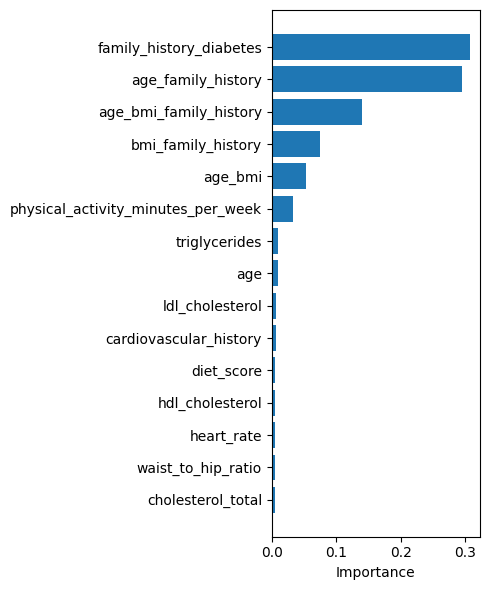

In [12]:
best_model = XGBClassifier( tree_method = 'hist', device = 'cuda', n_estimators = 100, max_depth = 6)
best_model.fit(train_inputs, train_target)

importance_df = pd.DataFrame({
    'feature' : train_inputs.columns,
    'importance' : best_model.feature_importances_}).sort_values('importance', ascending = False)

print(importance_df.head())

plt.figure(figsize=(5, 6))
plt.barh(importance_df['feature'].head(15), 
         importance_df['importance'].head(15))
plt.xlabel('Importance') 
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

train_size:  44800, auc: 0.6956, false_positive: 24960, false_negative: 12952
train_size: 931840, auc: 0.7209, false_positive: 24671, false_negative: 11303
train_size: 1818879, auc: 0.7209, false_positive: 24671, false_negative: 11303
train_size: 2705919, auc: 0.7209, false_positive: 24671, false_negative: 11303
train_size: 3592960, auc: 0.7209, false_positive: 24671, false_negative: 11303
train_size: 4480000, auc: 0.7209, false_positive: 24671, false_negative: 11303


/scratch-local/slurm-job-tmp-11874998/ipykernel_250/3839437464.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend()


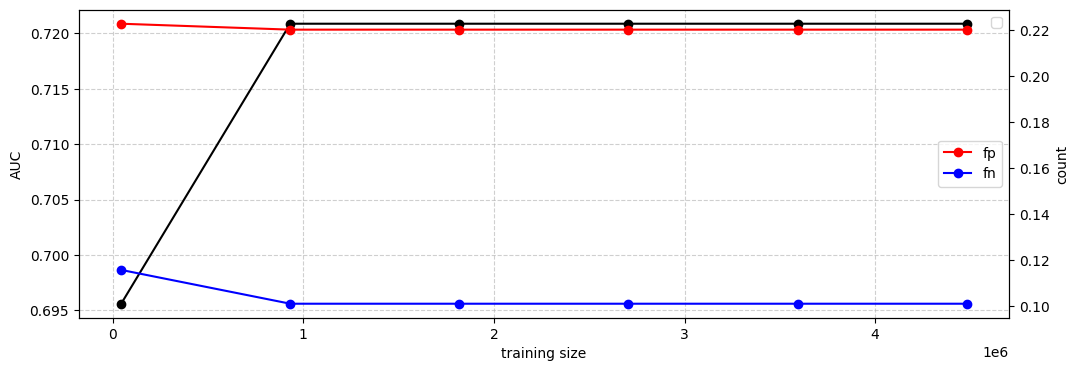

In [13]:
train_size = np.linspace(0.1,10,6)

learning_data = []

for size in train_size:

    sample_size = int(len(train_inputs) * size)

    input_sample  = train_inputs.iloc[:sample_size]
    target_sample = train_target.iloc[:sample_size]

    model = XGBClassifier(tree_method = 'hist', device = 'cuda', n_estimators = 100, max_depth = 6)
    model.fit(input_sample, target_sample)

    pred = model.predict(valid_inputs)
    pred_proba = model.predict_proba(valid_inputs)[:, 1]
    auc = roc_auc_score(valid_target, pred_proba)

    cm  = confusion_matrix(valid_target, pred)
    tn, fp, fn, tp = cm.ravel()

    learning_data.append({'train_size': sample_size, 'auc': auc, 'fp': fp/len(valid_target), 'fn': fn/len(valid_target)})
    
    print(f'train_size: {sample_size:6d}, auc: {auc:.4f}, false_positive: {fp}, false_negative: {fn}')

lc_df = pd.DataFrame(learning_data)

fig,axes = plt.subplots(1,1,figsize=(12, 4))

axes.plot(lc_df['train_size'], lc_df['auc'], marker='o', c='k')
axes.set_xlabel('training size')
axes.set_ylabel('AUC')
axes.grid(True,alpha=0.6,linestyle='--')
axes.legend()

ax1 = axes.twinx()
ax1.plot(lc_df['train_size'], lc_df['fp'], marker='o', label='fp', c='r')
ax1.plot(lc_df['train_size'], lc_df['fn'], marker='o', label='fn', c='b')
ax1.set_ylabel('count')
ax1.legend(); plt.show()




In [14]:
best_model = XGBClassifier(tree_method='hist', device='cuda', n_estimators=100)
best_model.fit(train_inputs, train_target)

pred = best_model.predict(valid_inputs)
pred_proba = best_model.predict_proba(valid_inputs)[:, 1]


cm = confusion_matrix(valid_target, pred)
tn, fp, fn, tp = cm.ravel()

print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
print('- '*10)
print("\n    classification report:")

print(classification_report(valid_target, pred))

predict_df = pd.DataFrame({
    'target label': valid_target,
    'prediction': pred,
    'proba': pred_proba
})

predict_df['wrong'] = predict_df['target label'] != predict_df['prediction']

predict_df['confidence'] = predict_df['proba'].apply( lambda x: x if x > 0.5 else 1-x )

# Most confident wrong predictions
error_df = predict_df[predict_df['wrong']].copy()
error_df = error_df.sort_values('confidence', ascending=False)

print('- '*10)
print("\n     moost confident error")
print(error_df.head(5000))


tp: 58493, tn: 17533, fp: 24671, fn: 11303
- - - - - - - - - - 

    classification report:
              precision    recall  f1-score   support

         0.0       0.61      0.42      0.49     42204
         1.0       0.70      0.84      0.76     69796

    accuracy                           0.68    112000
   macro avg       0.66      0.63      0.63    112000
weighted avg       0.67      0.68      0.66    112000

- - - - - - - - - - 

     moost confident error
        target label  prediction     proba  wrong  confidence
390955           0.0           1  0.990795   True    0.990795
96667            0.0           1  0.986044   True    0.986044
551201           0.0           1  0.982826   True    0.982826
294669           0.0           1  0.982616   True    0.982616
594384           0.0           1  0.981134   True    0.981134
...              ...         ...       ...    ...         ...
458883           0.0           1  0.749003   True    0.749003
43361            0.0           1  0.

In [15]:
num_samples = 5000

error_index  = error_df.head(num_samples).index
error_sample = valid_inputs.loc[error_index].copy()
error_sample['target label'] = valid_target.loc[error_index]
for cols in error_df.columns:
    if cols not in error_sample.columns:
        error_sample[cols] = error_df[cols].loc[error_index]

error_sample['fp'] = error_sample['target label'] == 0
error_sample['fn'] = error_sample['target label'] == 1

fpos = error_sample[ error_sample['fp'] == 1]
fneg = error_sample[ error_sample['fn'] == 1]

# print(error_sample.head())


# correct_cases = errors_df[~errors_df['wrong']].sample(num_samples)
# correct_index = correct_cases.index
# correct_sample = valid_inputs.loc[correct_index].copy()

# false_neg = errors_df[(errors_df['target label'] == 1) & (errors_df['prediction'] == 0)]
# fn_index  = false_neg.index
# fn_sample = valid_inputs.loc[fn_index]



In [132]:
fpos

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,bmi_family_history,age_bmi_family_history,cardio_comorbidity_count,target label,prediction,proba,wrong,confidence,fp,fn
390955,75,3,27,6.7,6.9,6.6,23.5,0.83,119,73,...,23.5,1762.5,1,0.0,1,0.990795,True,0.990795,True,False
96667,74,4,63,5.0,5.8,6.9,32.8,0.95,140,86,...,32.8,2427.2,3,0.0,1,0.986044,True,0.986044,True,False
551201,72,2,73,7.8,6.7,4.7,30.2,0.92,115,72,...,30.2,2174.4,2,0.0,1,0.982826,True,0.982826,True,False
294669,50,2,31,6.5,6.6,3.2,30.6,0.91,103,75,...,30.6,1530.0,1,0.0,1,0.982616,True,0.982616,True,False
594384,71,5,63,8.8,6.4,8.8,29.1,0.88,119,79,...,29.1,2066.1,2,0.0,1,0.981134,True,0.981134,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458883,57,1,43,6.7,8.1,5.9,34.6,0.95,128,83,...,0.0,0.0,0,0.0,1,0.749003,True,0.749003,True,False
43361,46,2,31,5.4,6.1,8.7,26.4,0.85,112,61,...,0.0,0.0,0,0.0,1,0.748983,True,0.748983,True,False
378208,68,2,23,8.1,7.0,3.3,29.5,0.98,124,83,...,0.0,0.0,1,0.0,1,0.748982,True,0.748982,True,False
287632,60,3,64,9.4,7.5,6.4,23.4,0.88,127,69,...,0.0,0.0,1,0.0,1,0.748941,True,0.748941,True,False


26


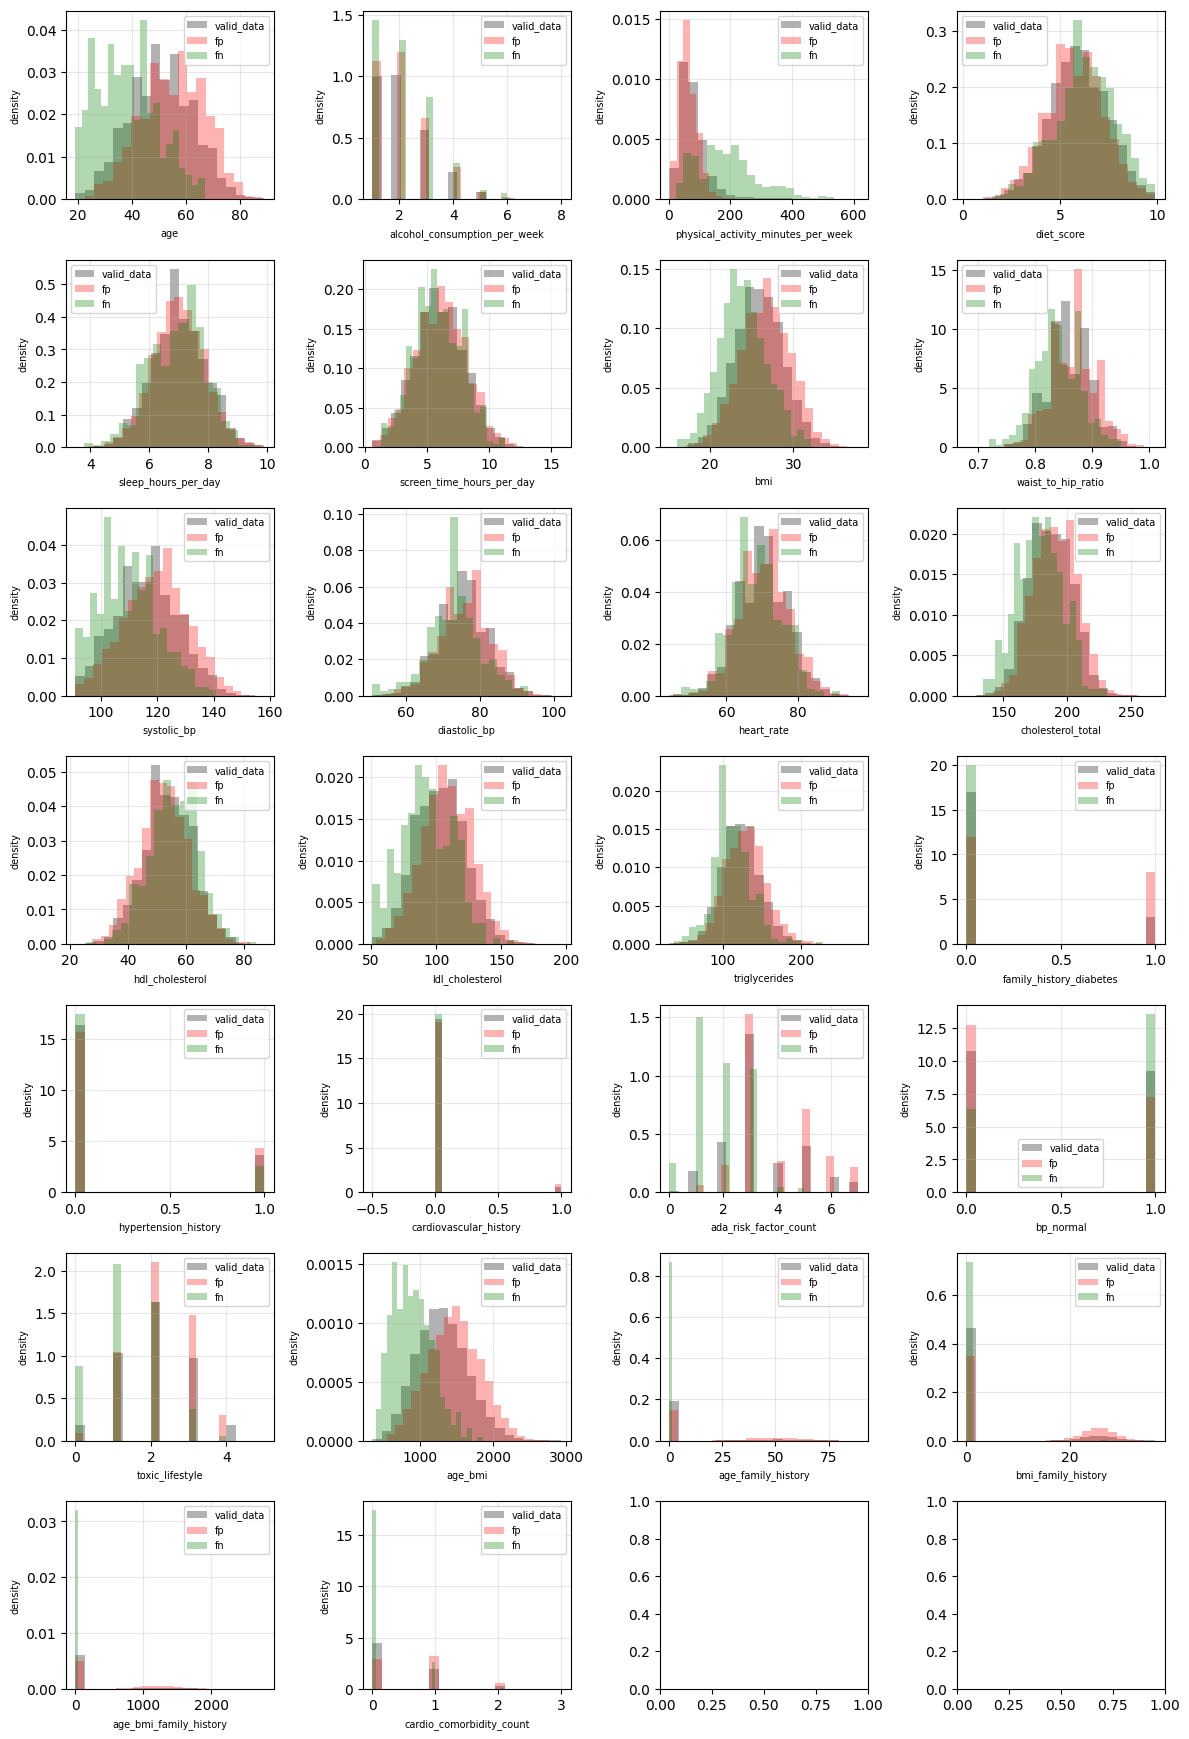

In [136]:
num_features = valid_inputs.columns.size; print(num_features)

nrows = num_features// 4 +1
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2.5*nrows))
axes = axes.flatten()
bins =20
alpha=0.3

for i, f in enumerate(valid_inputs.columns):
 
    axes[i].hist( valid_inputs[f] , bins=bins, alpha=alpha, label='valid_data', density = True, color='k')
    axes[i].hist( fpos[f] , bins=bins, alpha=alpha, label='fp', density = True, color='r')
    axes[i].hist( fneg[f] , bins=bins, alpha=alpha, label='fn', density = True, color='g')
    axes[i].legend(fontsize=7)
    axes[i].set_xlabel(f'{f}',fontsize=7)
    axes[i].set_ylabel('density',fontsize=7)
    axes[i].grid(True,alpha=0.3)
    
plt.tight_layout(); plt.show()
